In [1]:
import os
from tqdm import tqdm
import pandas as pd 
import numpy as np

import re
import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

#Lemmatizing and POSTagging

from nltk import pos_tag
from nltk.tag.stanford import StanfordPOSTagger
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk_lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer()
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import pickle



c:\users\me\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Initializing and decalring constant
* Stanford POS tagger importing

In [2]:
java_path = "C:/Program Files/Java/jdk1.8.0_45/bin/java.exe"
os.environ['JAVAHOME'] = java_path
#os.environ['STANFORD_POSTAGGER'] = "C:/Users/Me/Documents/stanford-postagger-full-2018-10-16"
os.environ['STANFORD_POSTAGGER'] = "D:/NLP/Library file/stanford-postagger-full-2018-10-16"
Stanford_postagger = StanfordPOSTagger(os.environ['STANFORD_POSTAGGER'] +'/models/english-bidirectional-distsim.tagger',os.environ['STANFORD_POSTAGGER']+'/stanford-postagger.jar')

tqdm.pandas() 

punct = set(string.punctuation)
stopWords = set(stopwords.words('english'))

# shuffle entier dataset
# preprocess
#before feeding to model to test/ valid/ train split


# Load dataset propely

In [3]:
# storing base  path to dataset directory
BASE_PATH = "C:/Users/Me/Desktop/ppr red/andrew/nlp/mlMastery/txt_sentoken"
CATAGORIES = ["neg","pos"]

df =pd.DataFrame({"review": [] ,"sentiment": []})

for catagorie in CATAGORIES :
    path = os.path.join(BASE_PATH,catagorie) #full path to folder
    ALL_DOCS = os.listdir(path) # storing all files in that path
    for doc in ALL_DOCS:
        if doc.endswith(".txt"):
            file =  open( os.path.join( path, doc) , 'r')
            df = df.append(pd.DataFrame({'review':file.read(), 'sentiment':CATAGORIES.index(catagorie)}, index=[0]),ignore_index=True)

# neg = 0 and pos = 1

# TODO's
* Every row is not null
* columns, no need to drop columns
* check for dublicates in review

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
review       2000 non-null object
sentiment    2000 non-null float64
dtypes: float64(1), object(1)
memory usage: 31.3+ KB


In [5]:
len(df[df.duplicated(subset=["review"])])

0

In [6]:
#  overall avg length of text review , before / after  any pre processing
def word_count_in_review(review):
    tokens = word_tokenize(review)
    return len(tokens)  

In [7]:
%%time
df["word_count"] = df["review"].apply(lambda x : word_count_in_review(x))

Wall time: 9.77 s


In [8]:
df.head()

,review,sentiment,word_count
0,"plot : two teen couples go to a church party ,...",0.0,841
1,the happy bastard's quick movie review \ndamn ...,0.0,291
2,it is movies like these that make a jaded movi...,0.0,561
3,""" quest for camelot "" is warner bros . ' firs...",0.0,574
4,synopsis : a mentally unstable man undergoing ...,0.0,855


# Freq dist plot and Statistics of text data

In [9]:
#freq distribution lenght of data
def stats_of_freq_distribution(freq_column):
    print("MEAN length of data set :",np.mean(freq_column))
    print("MEDIAN length of data set :",np.median(freq_column))
    print("STD DEV length of data set :",np.std(freq_column))
    print("MAX token of data set :",np.max(freq_column))
    print("MIN token of data set :",np.min(freq_column))
    
def plot_length_distribution(freq_column):
    plt.hist(freq_column, bins=50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


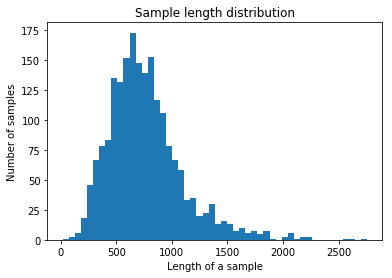

In [10]:
plot_length_distribution(df['word_count'])

In [11]:
#mean length of data set
stats_of_freq_distribution(df['word_count'])
print("MEAN of Negative Sentiment",np.mean(df[df['sentiment'] == 0]['word_count']))
print("MEAN of Positive Sentiment",np.mean(df[df['sentiment'] == 1]['word_count']))

MEAN length of data set : 762.488
MEDIAN length of data set : 712.5
STD DEV length of data set : 335.3428303333769
MAX token of data set : 2753
MIN token of data set : 18
MEAN of Negative Sentiment 721.772
MEAN of Positive Sentiment 803.204


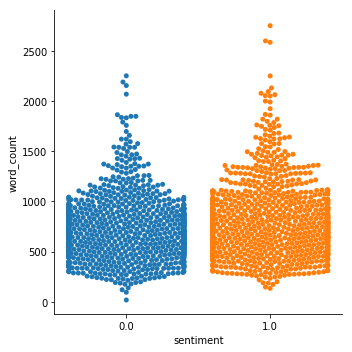

In [12]:
# plot +ve vs -ve text length of review 
sns.catplot(x="sentiment", y="word_count", kind="swarm", data=df)


# Insprcting Dataset

In [13]:
#word whose count above 2000 and abov 2.5K are only 3
df[df['word_count']>2000].head(15)

,review,sentiment,word_count
100,warning : spoilers are included in this review...,0.0,2070
107,* * * the following review contains spoilers ...,0.0,2191
428,"the above is dialogue from this film , taken a...",0.0,2156
732,i think that saying that the x-files is one of...,0.0,2253
1146,"seen may 19 , 1999 at 5 p . m . at the crossga...",1.0,2132
1256,most people fit into two different categories ...,1.0,2096
1345,alien 3 is the only alien film i have seen in ...,1.0,2055
1501,as much as i wanted to like this film as i wen...,1.0,2052
1512,it may seem weird to begin a film about glam r...,1.0,2079
1552,note : some may consider portions of the follo...,1.0,2753


In [14]:
df[df['word_count']<250].iloc[25]["review"]

'this three hour movie opens up with a view of singer/guitar player/musician/composer frank zappa rehearsing with his fellow band members . \nall the rest displays a compilation of footage , mostly from the concert at the palladium in new york city , halloween 1979 . \nother footage shows backstage foolishness , and amazing clay animation by bruce bickford . \nthe performance of " titties and beer " played in this movie is very entertaining , with drummer terry bozzio supplying the voice of the devil . \nfrank\'s guitar solos outdo any van halen or hendrix i\'ve ever heard . \nbruce bickford\'s outlandish clay animation is that beyond belief with zooms , morphings , etc . and actually , it doesn\'t even look like clay , it looks like meat . \n'

# Too many \n though out the data set

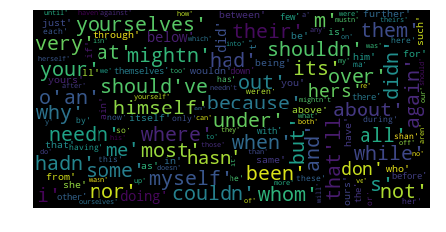

In [15]:
wordcloud  = WordCloud(
    background_color='black',
   # stopwords=stopWords,
    max_words=150,
    max_font_size=20, 
    random_state=42
    ).generate(str(stopWords))#(str(df_dublicates["Review Text"]))
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show()


In [16]:
punct

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

# pre processing step 1

In [17]:
#BASIC 
# 1. tokenizer (many other variants)
# 2. lowercase tokens
## spelling correction error using TEXTBLOB
# 3. remove stopwords **** might need it for input in embedding.. specially comma n  fullstop
# 4. remove punctuation
# can include additional STOPWORD / TOKEN / PUNCTUATION

def preProcess(review):
    token = word_tokenize(review) 
    tokens = [t.lower() for t in token]
    filterd_words = [word for word in tokens if word not in stopWords]
    return ' '.join(text for text in filterd_words if text not in punct)

#for next iter keep punc / stopwords

#  New df to store preprocessed file and its results

In [18]:
df_preprocessed = pd.DataFrame()

In [19]:
#applying preprocessing
df_preprocessed['review'] = df['review'].progress_apply(lambda x : preProcess(x))

100%|█████████████████████████████████████| 2000/2000 [00:10<00:00, 179.08it/s]


# Preprocess Handle POS and lemmatization step 2

In [20]:
# You need to convert the tag from the pos_tagger to one of the four "syntactic categories" that wordnet recognizes,
# then pass that to the lemmatizer as the word_pos.
# so lemmatizer can process it

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None 
    
#tagged is defined globally

def nltk_lemma(tag):
    global tagged
    lst=[]
    for word, tag in tagged:
        
        wntag = get_wordnet_pos(tag)
        
        if wntag is None:# not supply tag in case of None
            lemma = nltk_lemmatizer.lemmatize(word)
            lst.append(lemma)
            #return " ".join(lemma)
            #print(lemma)
        else:
            lemma = nltk_lemmatizer.lemmatize(word, pos=wntag)
            lst.append(lemma)
            #return " ".join(lemma)
            #print(lemma)
            
    return lst


def POS_lemmatize(review):
    global tagged
    #normal tagger
    tagged = pos_tag(word_tokenize(review))
    #stanford tagger
    #tagged = Stanford_postagger.tag(word_tokenize(review))# imp word tokenize and repective POS
    return " ".join(nltk_lemma(tagged))# retuns setence after lemmatising

# Here using normal pos_tag as stanford is giving error

In [21]:
'''
%%time
df_preprocessed['review'] = df_preprocessed["review"].apply(lambda x : POS_lemmatize(x) )
'''
#using pos_tag and not he stanford tagger
df_preprocessed['review'] = df_preprocessed["review"].progress_map(lambda x : POS_lemmatize(x) )

100%|██████████████████████████████████████| 2000/2000 [00:54<00:00, 36.64it/s]


In [22]:
#applying word count of pre processed review
df_preprocessed["word_count"] = df_preprocessed["review"].progress_apply(lambda x : word_count_in_review(x))

100%|█████████████████████████████████████| 2000/2000 [00:03<00:00, 571.07it/s]


In [23]:
df_preprocessed.head()
df_preprocessed['sentiment'] = df['sentiment']
#stats_of_freq_distribution(df_preprocessed['word_count'])

In [26]:
df_preprocessed.columns

Index(['review', 'word_count', 'sentiment'], dtype='object')

# Org. data plot VS processed data plot

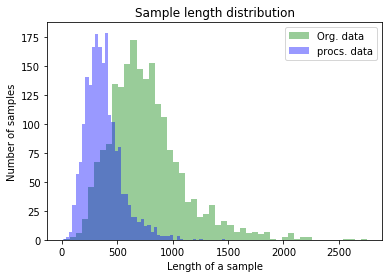

In [24]:
plt.hist(df['word_count'], bins=50,color='green',alpha=0.4, label="Org. data" )
plt.hist(df_preprocessed['word_count'], bins=50,color='blue',alpha=0.4,label="procs. data")
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.legend()
plt.show()

# Shuffle DataFrame rows

In [25]:
#Shuffling since 1ok +ve sample followed by 10k -ve sample
#df.reindex(np.random.permutation(df.index))   #numpy way of doing
#df.sample(frac=1).reset_index(drop=True)      #pandas way of doing
df_preprocessed.sample(frac=1).reset_index(drop=True)   

,review,word_count,sentiment
0,phew mess fifth collaboration director rich- a...,280,0.0
1,one point brian de palma 's crime epic scarfac...,358,1.0
2,verdict spine-chilling drama horror maestro st...,457,1.0
3,extraordinary year australian film `` shine ``...,374,1.0
4,inspired 1958 film house haunt hill star vince...,295,0.0
5,towards middle `` sweet hereafter `` crowded s...,289,1.0
6,since film debut 1984 tightly work texas thril...,456,1.0
7,first hear contact hype build sci-fi blockbust...,370,1.0
8,deuce bigalow rob schneider clean fish tank ye...,295,0.0
9,`` disney stick-to-what-you-do-best `` rule st...,473,0.0


In [27]:
pd.to_pickle(df_preprocessed, "./pickles/1_processed_pos_tag.pkl")

# Deciding seq length for N.N 

In [28]:
stats_of_freq_distribution(df_preprocessed['word_count'])

MEAN length of data set : 373.0535
MEDIAN length of data set : 350.0
STD DEV length of data set : 161.66131150572173
MAX token of data set : 1477
MIN token of data set : 7


In [29]:
# MEAN + 2 * std dev
max_tokens = 373 + 2 * 161
max_tokens

695

# Covers about 95% of data

In [30]:
np.sum(df_preprocessed['word_count'] < max_tokens) / len(df_preprocessed['word_count'])

0.952

# Vocab of tf-idf terms

In [28]:
'''
create a vocabulary of words in the corpous
from the vocab choose word from original vector
MEAN length of data set : 373.0535
MEDIAN length of data set : 350.0

input_dim = size of the vocabula
input_length = input_seq_lense;   For example, if all of your input documents are comprised of 1000 words, this would be 1000.

'''


'\ncreate a vocabulary of words in the corpous\nfrom the vocab choose word from original vector\nMEAN length of data set : 373.0535\nMEDIAN length of data set : 350.0\n\ninput_dim = size of the vocabula\ninput_length = input_seq_lense;   For example, if all of your input documents are comprised of 1000 words, this would be 1000.\n\n'

In [31]:
df_preprocessed.head()

,review,word_count,sentiment
0,plot two teen couple go church party drink dri...,358,0.0
1,happy bastard 's quick movie review damn y2k b...,144,0.0
2,movie like make jaded movie viewer thankful in...,276,0.0
3,`` quest camelot `` warner bros first feature-...,313,0.0
4,synopsis mentally unstable man undergo psychot...,402,0.0
